In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline




from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import random

In [120]:
df_train = pd.read_csv('train.csv')

In [121]:
input_feature_train_df = df_train.drop(['Item_Outlet_Sales'],axis=1)
target_feature_train_df = df_train['Item_Outlet_Sales']

In [122]:
input_feature_train_df['Item_Fat_Content'] = input_feature_train_df['Item_Fat_Content'].replace(['LF','low fat','reg'],['Low Fat','Low Fat','Regular'])

In [123]:
input_feature_train_df['Item_Identifier'] = input_feature_train_df['Item_Identifier'].apply(lambda x:x[:2])

In [124]:
input_feature_train_df['Outlet_age'] = 2013 - input_feature_train_df['Outlet_Establishment_Year']
            input_feature_train_df.drop(columns=['Outlet_Establishment_Year'],inplace=True)

In [125]:
input_feature_train_df.loc[input_feature_train_df['Item_Identifier']=='NC','Item_Fat_Content'] = 'Non Edible'

In [126]:
input_feature_train_df.drop(columns=['Item_Type','Outlet_Identifier'],inplace = True)

In [127]:
def numerical_categorical_column(dataframe):
        '''
        This function returns the numerical and categorical column 
        return numerical_columns,categorical_columns
        '''
        numerical_columns = [i for i in dataframe.columns if  dataframe[i].dtype != 'O']
        categorical_columns = [i for i in dataframe.columns if  dataframe[i].dtype == 'O']
        return numerical_columns,categorical_columns

In [128]:
numerical_features_train,categorical_features_train = numerical_categorical_column(input_feature_train_df)

In [129]:
def encoding(dataframe):
        # Changing Values of item Identifier because sales of item identifier are more so giving high value
        Item_Identifier = {'DR': 1, 'FD': 3, 'NC': 2}
        # Changing Values of Item_Fat_Content because sales of Regular are more so giving high value
        Item_Fat_Content = {'Low Fat': 1, 'Non Edible': 0, 'Regular': 2}
        # Changing Values of outlet size because sales in medium size outlets are more so giving high value
        Outlet_Size = {'High': 2, 'Medium': 3, 'Small': 1, np.nan: 0} 
        Outlet_Location_Type = {'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2}
        Outlet_Type = {'Grocery Store': 0,
        'Supermarket Type1': 2,
        'Supermarket Type2': 1,
        'Supermarket Type3': 3}
        for i in dataframe.columns:
            if i == "Item_Identifier":
                dataframe[i] = dataframe[i].map(Item_Identifier)
            elif i =="Item_Fat_Content":
                dataframe[i] = dataframe[i].map(Item_Fat_Content)
            elif i =="Outlet_Size":
                dataframe[i] = dataframe[i].map(Outlet_Size)
            elif i =="Outlet_Location_Type":
                dataframe[i] = dataframe[i].map(Outlet_Location_Type)
            elif i =="Outlet_Type":
                dataframe[i] = dataframe[i].map(Outlet_Type)
            else: 
                print("Not Able to Encode")
        
        return dataframe

In [130]:
train_num_df = input_feature_train_df[numerical_features_train]
train_cat_df = input_feature_train_df[categorical_features_train]
#train_cat_df = encoding(train_cat_df)


# Encoding 
encoder = LabelEncoder()

for i in categorical_features_train:
    train_cat_df[i] = encoder.fit_transform(train_cat_df[i])
    
train_cat_df['Outlet_Size'].replace(3,np.nan,inplace=True)

In [143]:
numerical_features_train

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_age']

In [144]:
input_feature_train_df = pd.concat([train_num_df,train_cat_df],axis=1)
input_feature_train_df

,Item_Weight,Item_Visibility,Item_MRP,Outlet_age,Item_Identifier,Item_Fat_Content,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.300,0.016047,249.8092,14,1,0,1.0,0,1
1,5.920,0.019278,48.2692,4,0,2,1.0,2,2
2,17.500,0.016760,141.6180,14,1,0,1.0,0,1
3,19.200,0.000000,182.0950,15,1,2,NaN,2,0
4,8.930,0.000000,53.8614,26,2,1,0.0,2,1
...,...,...,...,...,...,...,...,...,...
8518,6.865,0.056783,214.5218,26,1,0,0.0,2,1
8519,8.380,0.046982,108.1570,11,1,2,NaN,1,1
8520,10.600,0.035186,85.1224,9,2,1,2.0,1,1
8521,7.210,0.145221,103.1332,4,1,2,1.0,2,2


<AxesSubplot:xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>

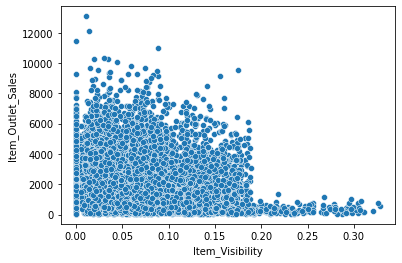

In [147]:
# Item Visibility 
sns.scatterplot(x=input_feature_train_df['Item_Visibility'],y=df_train['Item_Outlet_Sales'])

In [134]:
def get_dats_transformer_object(numerical,categorical):
        
           

            num_pipeline = Pipeline(steps=[
                                     ('imputer',KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)),
                                     ('scaler',StandardScaler())
                                    ])


            cat_pipeline = Pipeline(steps=[
                                    ('imputer',KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)),
                                    
                                    ])

            preprocessing = ColumnTransformer([
                                    ('num_pipeline', num_pipeline, numerical),
                                    ('cat_pipeline', cat_pipeline, categorical),
            ])



            return preprocessing

In [135]:
 preprocessing_obj = get_dats_transformer_object(numerical_features_train,categorical_features_train)
input_feature_train_array = preprocessing_obj.fit_transform(input_feature_train_df)
input_feature_train_array 

array([[-0.81853286, -0.97073217,  1.74745381, ...,  1.        ,
         0.        ,  1.        ],
       [-1.59119397, -0.90811123, -1.48902325, ...,  1.        ,
         2.        ,  2.        ],
       [ 1.05597041, -0.95691733,  0.01004021, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.52135551, -0.59978449, -0.89720755, ...,  2.        ,
         1.        ,  1.        ],
       [-1.2963026 ,  1.53287976, -0.60797692, ...,  1.        ,
         2.        ,  2.        ],
       [ 0.43875592, -0.41193591, -1.05226104, ...,  2.        ,
         0.        ,  1.        ]])

In [136]:
processod_train_df = pd.DataFrame(input_feature_train_array,columns=input_feature_train_df.columns)

In [137]:
processod_train_df = pd.concat([processod_train_df,target_feature_train_df],axis=1)
processod_train_df['Item_Identifier'].unique

<bound method Series.unique of 0       1.0
1       0.0
2       1.0
3       1.0
4       2.0
       ... 
8518    1.0
8519    1.0
8520    2.0
8521    1.0
8522    0.0
Name: Item_Identifier, Length: 8523, dtype: float64>

In [138]:
processod_train_df

,Item_Weight,Item_Visibility,Item_MRP,Outlet_age,Item_Identifier,Item_Fat_Content,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,-0.818533,-0.970732,1.747454,-0.139541,1.0,0.0,1.0,0.0,1.0,3735.1380
1,-1.591194,-0.908111,-1.489023,-1.334103,0.0,2.0,1.0,2.0,2.0,443.4228
2,1.055970,-0.956917,0.010040,-0.139541,1.0,0.0,1.0,0.0,1.0,2097.2700
3,1.444587,-1.281758,0.660050,-0.020085,1.0,2.0,0.0,2.0,0.0,732.3800
4,-0.903114,-1.281758,-1.399220,1.293934,2.0,1.0,0.0,2.0,1.0,994.7052
...,...,...,...,...,...,...,...,...,...,...
8518,-1.375169,-0.181193,1.180783,1.293934,1.0,0.0,0.0,2.0,1.0,2778.3834
8519,-1.028843,-0.371154,-0.527301,-0.497909,1.0,2.0,2.0,1.0,1.0,549.2850
8520,-0.521356,-0.599784,-0.897208,-0.736822,2.0,1.0,2.0,1.0,1.0,1193.1136
8521,-1.296303,1.532880,-0.607977,-1.334103,1.0,2.0,1.0,2.0,2.0,1845.5976


In [139]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [140]:
# LinearRegression

X = processod_train_df.drop(columns=['Item_Outlet_Sales'])
y = processod_train_df['Item_Outlet_Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=22)
print(f'Shape of data:{processod_train_df.shape}')
print(f'Shape of X_train:{X_train.shape}')
print(f'Shape of y_train:{y_train.shape}')
print(f'Shape of X_test:{X_test.shape}')
print(f'Shape of y_test:{y_test.shape}')
LR = LinearRegression()
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

R2 = r2_score(y_test,y_pred)
print(f'accuracy {R2}')

Shape of data:(8523, 10)
Shape of X_train:(6818, 9)
Shape of y_train:(6818,)
Shape of X_test:(1705, 9)
Shape of y_test:(1705,)
accuracy 0.48858223510568477


In [141]:
RF= RandomForestRegressor()
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)

R2 = r2_score(y_test,y_pred)
print(f'accuracy {R2}')

accuracy 0.5369384226095455


In [142]:
XB = XGBRegressor()
XB.fit(X_train,y_train)
y_pred = XB.predict(X_test)

R2 = r2_score(y_test,y_pred)
print(f'accuracy {R2}')

accuracy 0.5004398769021449
